# Podcast Reviews Data Analysis Part 2: Research Questions and Statistical Inference

Dataset link: https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28

**Note**: Part 1 of this analysis is in Jupyter notebook called data_exploration.ipynb

### Objectives:
- Perform EDA of the dataset;
- Explore existing patterns and peculiarities if existant;
- Perform a statistical test to check the hypotheis;
- Form conclusions and suggestions on what makes a podcast successful, more highly reviewed.

### Bias and limitations:
- The reviews were added with different frequency;
- There are some popular podcasts missing (as seen on a discussion about this dataset);
- The names of the categories of podcasts aren't always the same as seen on iTunes (as seen on a discussion about this dataset);
- There are many duplicate reviews from the same authors on the same podcasts;
- Most reviews were added between 2019 and 2021, there is little amount of reviews for the period 2005-2015.
- There are reviews that are not in English.

# 0. Importing data and libraries

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [27]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from matplotlib.gridspec import GridSpec
from ydata_profiling import ProfileReport
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

import helper_functions as hf

import sqlite3 as sql

sns.set_style("darkgrid")

<IPython.core.display.Javascript object>

In [4]:
# connect to the database
conn = sql.connect("database.sqlite")

# create a cursor
c = conn.cursor()

<IPython.core.display.Javascript object>

In [5]:
# loading the tables into dataframes
podcasts = pd.read_sql(
    """
            SELECT *
            FROM podcasts;
            """,
    conn,
)

runs = pd.read_sql(
    """
            SELECT *
            FROM runs;
            """,
    conn,
)

categories = pd.read_sql(
    """
            SELECT *
            FROM categories;
            """,
    conn,
)

reviews = pd.read_sql(
    """
            SELECT *
            FROM reviews;
            """,
    conn,
)

<IPython.core.display.Javascript object>

# 1. Answering research questions

## 1.1. What are top(bottom)-10 categories based on the number of podcasts? 

##### Main insights and observations:
- There more podcasts on wellness and self-development and less on more specific, professional topics.

##### Additional notes:
- We can hypothetically correlate the number of podcasts in different categories with the size of the audiences. It makes sense that more general topics have bigger audiences.

<Axes: title={'center': 'Top-10 categories (by # of podcasts)'}, xlabel='Category', ylabel='Count'>

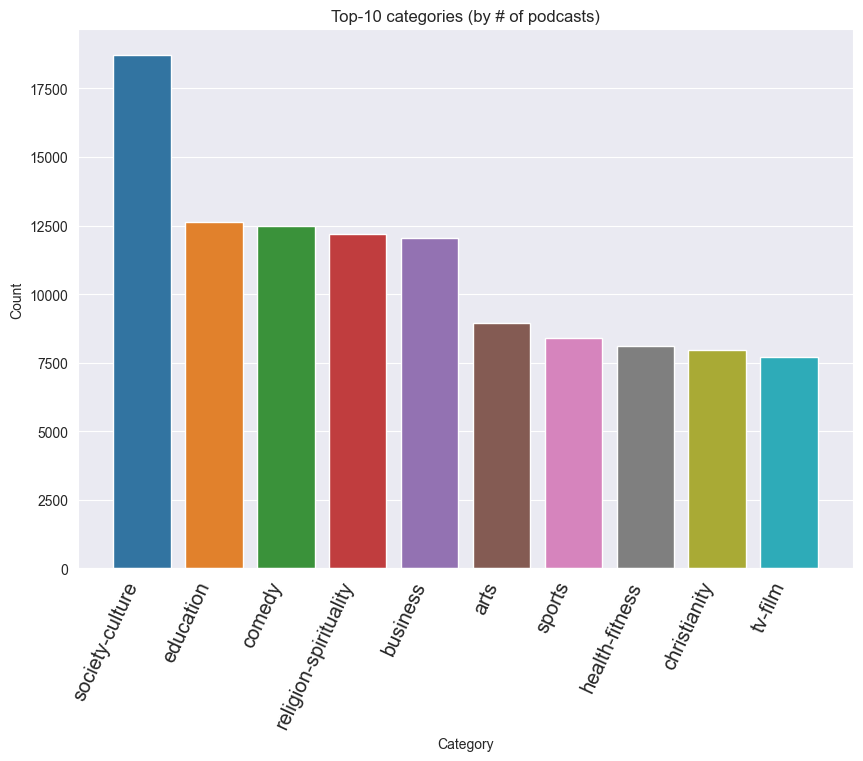

<IPython.core.display.Javascript object>

In [5]:
top_order = categories["category"].value_counts().iloc[:10].index

# plot the top-10 course organizations
hf.plot_sns_countplot(
    categories,
    x="category",
    plot_order=top_order,
    x_label="Category",
    y_label="Count",
    title="Top-10 categories (by # of podcasts)",
)

<Axes: title={'center': 'Bottom-10 categories (by # of podcasts)'}, xlabel='Category', ylabel='Count'>

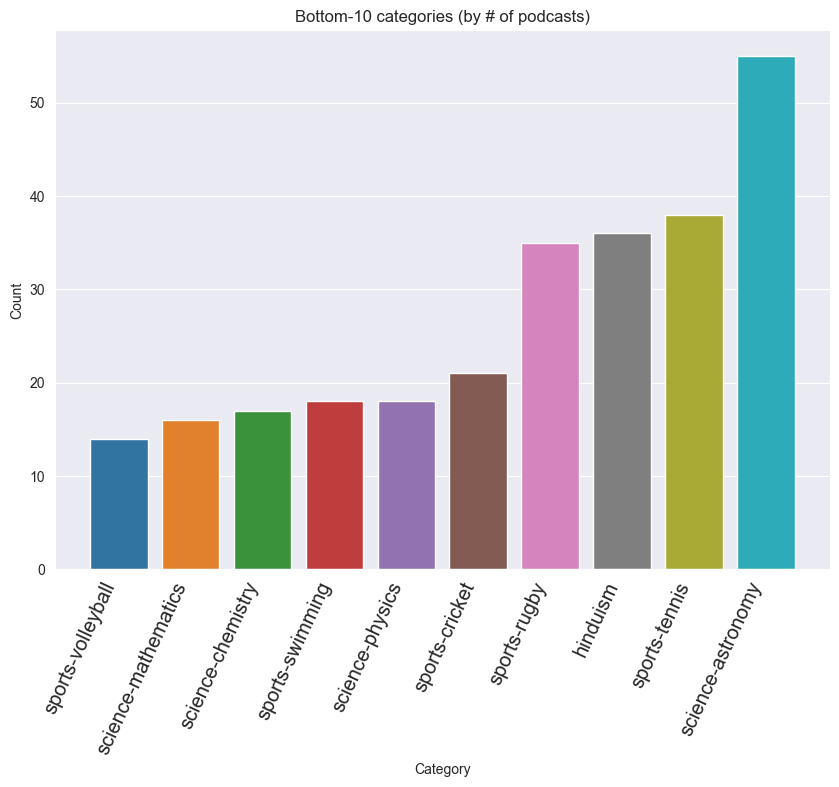

<IPython.core.display.Javascript object>

In [6]:
bottom_order = list(reversed(categories["category"].value_counts().iloc[-10:].index))

# plot the bottom-10 course organizations
hf.plot_sns_countplot(
    categories,
    x="category",
    plot_order=bottom_order,
    x_label="Category",
    y_label="Count",
    title="Bottom-10 categories (by # of podcasts)",
)

## 1.2. What are the shares of positive/negative reviews in the top-10 categories by the number of podcasts? 

##### Main insights and observations:
- The biggest amount of positive reviews are in categories society-culture, comedy, education, business, and health-fitness. Though, if we consider the share of positive reviews in the overall amount of reviews for each category, the highest percentage of satisfied reviewers are in categories business, religion-spirituality, christianity, education, and health-fitness.
- The highest share of negative reviews can be observed in categories news-daily-news, true-crime, and news-politics.

##### Additional notes:
- We consider ratings 4-5 to be positive and 1-3 to be negative.
- We mainly focus on the top-10 categories based on the number of podcasts in that category.

In [8]:
category_reviews_share = pd.read_sql(
    """
        SELECT c.category, 
        COUNT(DISTINCT c.podcast_id) AS num_podcasts,
        COUNT(*) AS num_reviews,
        SUM(CASE 
              WHEN r.rating > 3 THEN 1 ELSE 0 END) 
        AS num_positive,
        (SUM(CASE 
               WHEN r.rating > 3 
               THEN 1 ELSE 0 END) * 1.0 / COUNT(r.podcast_id)) 
        AS positive_share,
        SUM(CASE 
              WHEN r.rating <= 3 THEN 1 ELSE 0 END) 
        AS negative_count,
        (SUM(CASE 
               WHEN r.rating <= 3 
               THEN 1 ELSE 0 END) * 1.0 / COUNT(r.podcast_id)) 
        AS negative_share
        FROM categories c
        JOIN reviews r 
        ON c.podcast_id = r.podcast_id
        GROUP BY c.category
        ORDER BY num_podcasts DESC
        LIMIT 10;
            """,
    conn,
)

category_reviews_share

,category,num_podcasts,num_reviews,num_positive,positive_share,negative_count,negative_share
0,society-culture,18710,441874,385416,0.872231,56458,0.127769
1,education,12628,221831,210731,0.949962,11100,0.050038
2,comedy,12464,350848,314287,0.895792,36561,0.104208
3,religion-spirituality,12190,146633,140101,0.955453,6532,0.044547
4,business,12058,210081,200919,0.956388,9162,0.043612
5,arts,8953,136508,126334,0.925470,10174,0.074530
6,sports,8388,175709,156839,0.892607,18870,0.107393
7,health-fitness,8123,174310,164064,0.941220,10246,0.058780
8,christianity,7954,86341,82317,0.953394,4024,0.046606
9,tv-film,7714,169915,147063,0.865509,22852,0.134491


<IPython.core.display.Javascript object>

In [9]:
# define the list of top categories based on the number of reviews
top_categories = category_reviews_share.category.values.tolist()

# get a dataframe with positive reviews encoded as 1
category_positive_encoding = pd.read_sql(
    """
        SELECT c.category, 
               CASE 
                 WHEN r.rating > 3 THEN 1 ELSE 0 END
               AS positive_rating
        FROM categories c
        JOIN reviews r 
        ON c.podcast_id = r.podcast_id
        WHERE c.category IN ({})
        ORDER BY c.category;
            """.format(
        ",".join("?" * len(top_categories)),
    ),
    conn,
    params=top_categories,
)

category_positive_encoding

,category,positive_rating
0,arts,1
1,arts,1
2,arts,0
3,arts,1
4,arts,1
...,...,...
2114045,tv-film,1
2114046,tv-film,1
2114047,tv-film,1
2114048,tv-film,1


<IPython.core.display.Javascript object>

In [10]:
pd.read_sql(
    """
        SELECT c.category, COUNT(*) AS num_reviews,
        SUM(CASE WHEN r.rating > 3 THEN 1 ELSE 0 END) AS num_positive,
        (SUM(CASE WHEN r.rating > 3 THEN 1 ELSE 0 END) * 1.0 / COUNT(r.podcast_id)) AS positive_share
        FROM categories c
        JOIN reviews r 
        ON c.podcast_id = r.podcast_id
        GROUP BY c.category
        ORDER BY positive_share DESC
        LIMIT 5;
            """,
    conn,
)

,category,num_reviews,num_positive,positive_share
0,sports-rugby,167,167,1.000000
1,business-marketing,28869,28420,0.984447
2,sports-swimming,130,127,0.976923
3,business-entrepreneurship,80242,78333,0.976209
4,business-non-profit,2570,2508,0.975875


<IPython.core.display.Javascript object>

In [11]:
pd.read_sql(
    """
        SELECT c.category, COUNT(*) AS num_reviews,
        SUM(CASE 
              WHEN r.rating <= 3 
              THEN 1 ELSE 0 END)
        AS num_negative,
        (SUM(CASE 
               WHEN r.rating <= 3 
               THEN 1 ELSE 0 END) * 1.0 / COUNT(r.podcast_id)) 
        AS negative_share
        FROM categories c
        JOIN reviews r 
        ON c.podcast_id = r.podcast_id
        GROUP BY c.category
        ORDER BY negative_share DESC
        LIMIT 5;
            """,
    conn,
)

,category,num_reviews,num_negative,negative_share
0,news-daily-news,15030,4425,0.294411
1,true-crime,162550,39515,0.243094
2,news-politics,47888,10492,0.219095
3,society-culture-documentary,31338,6248,0.199375
4,news,180552,35074,0.194260


<IPython.core.display.Javascript object>

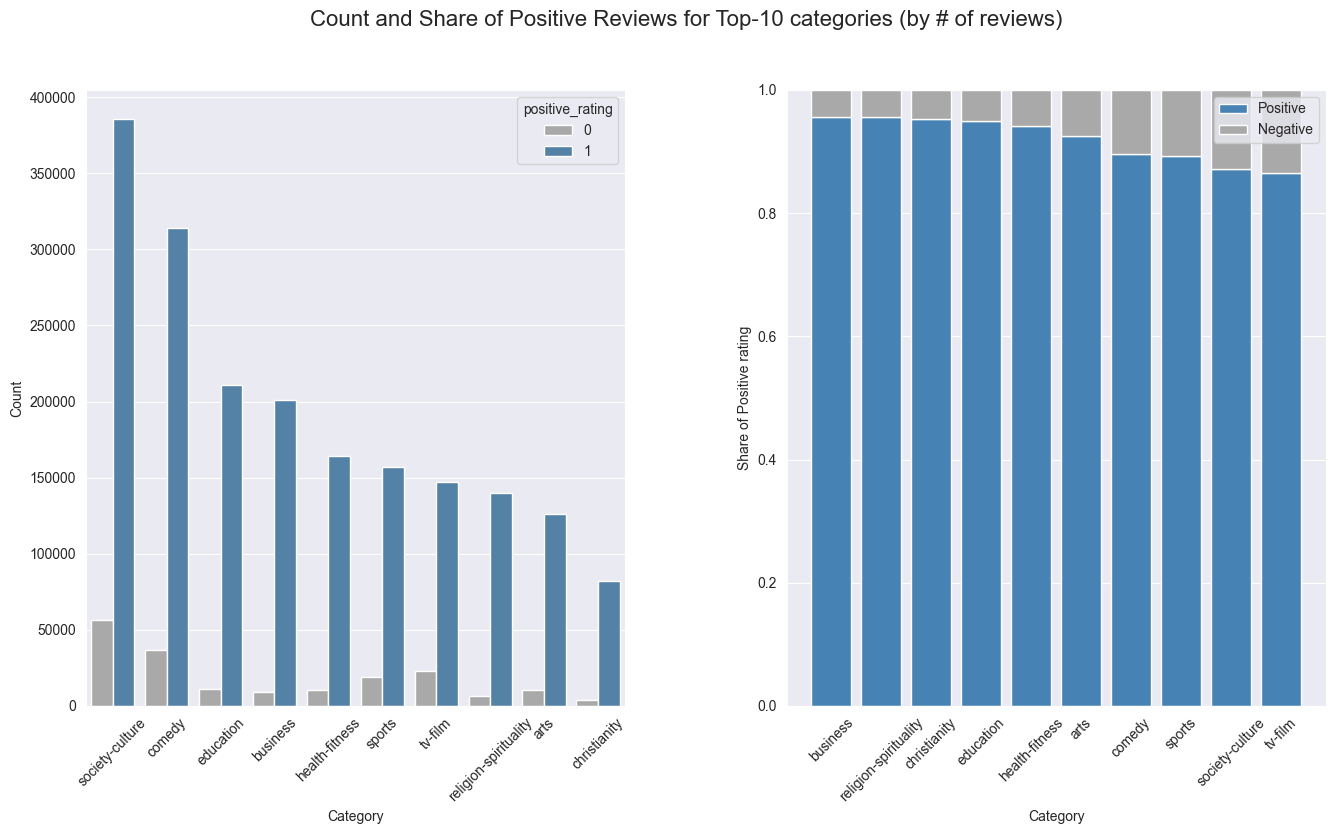

<IPython.core.display.Javascript object>

In [18]:
# Sort the categories by the number of positive reviews in descending order
category_order = (
    category_positive_encoding.groupby("category")["positive_rating"]
    .sum()
    .sort_values(ascending=False)
    .index
)

hf.plot_count_percent_barplots_by_category(
    category_positive_encoding,
    "category",
    "positive_rating",
    "Count and Share of Positive Reviews for Top-10 categories (by # of reviews)",
    category_order,
)

## 1.3. What are the distributions of sentiment scores of the reviews for top podcast categories?

##### Main insights and observations:
- Podcasts in business category tend to get more positive reviews overall.

##### Additional notes:
- Since the size of data is huge, we have decided to analyze only reviews from 2020 (the year when the biggest amount of reviews were added)

In [79]:
query = """
    SELECT r.podcast_id,  
           lower(replace(replace(replace(r.content, '.', ''), ',', ''), '?', '')) AS clean_text,
           r.rating,
           r.category,
           strftime('%Y', r.created_at) AS year
    FROM (
        SELECT r.*, c.category,
               ROW_NUMBER() OVER (PARTITION BY c.category ORDER BY RANDOM()) AS row_num
        FROM reviews r 
        JOIN categories c
        ON c.podcast_id = r.podcast_id
        WHERE c.category IN ({}) 
         AND replace(replace(replace(r.content, '.', ''), ',', ''), '?', '') GLOB '[a-zA-Z]*'
         AND strftime('%Y', r.created_at) = '2020'
    ) r
    WHERE r.row_num <= 1000
    ORDER BY r.category;
""".format(
    ",".join("?" * len(top_categories[:5]))
)

params = top_categories[:5]

# Execute the SQL query and return the results as a pandas dataframe
reviews_top_cat = pd.read_sql(query, conn, params=params)


reviews_top_cat

,podcast_id,clean_text,rating,category,year
0,ac206ef84a52e714b9747adfd1cd7cd6,i recently saw thom speak at a conference this...,5,business,2020
1,e4f40593687b648068b986ad01bacb7d,cathy you have helped get smart mom entreprene...,5,business,2020
2,db00c6bbc107d8ff545d790e99f4ee55,i watched the world premiere of the miracle mo...,5,business,2020
3,f60d3949099e54d73135c258a324768d,interesting content lots to learn here i enj...,5,business,2020
4,eca4b4c4e2c368bf63d82c7f7c9e404c,i absolutely adore this podcast! i have listen...,5,business,2020
...,...,...,...,...,...
4995,da8fc675052df9f7d581cd06f5bb6940,i travel a lot for work moved to a new city an...,5,society-culture,2020
4996,c787e85061615f1896b5f51acd0fbb56,the writing is decent but brooke’s delivery is...,2,society-culture,2020
4997,d2c4541914178820ce0dfd8f3b23223a,it seems like a good podcast but i have to fas...,2,society-culture,2020
4998,e8f878577a62c621d192a91cf62fdb58,i’m really loving this podcast the writing mak...,5,society-culture,2020


<IPython.core.display.Javascript object>

In [80]:
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")


# calculate the sentiment score of each review
def get_sentiment_score(text):
    doc = nlp(text)
    return doc._.blob.polarity


# apply the get_sentiment_score function to the clean_text column
reviews_top_cat["sentiment_score"] = reviews_top_cat["clean_text"].apply(
    get_sentiment_score
)

<IPython.core.display.Javascript object>

In [81]:
reviews_top_cat

,podcast_id,clean_text,rating,category,year,sentiment_score
0,ac206ef84a52e714b9747adfd1cd7cd6,i recently saw thom speak at a conference this...,5,business,2020,0.562338
1,e4f40593687b648068b986ad01bacb7d,cathy you have helped get smart mom entreprene...,5,business,2020,0.213728
2,db00c6bbc107d8ff545d790e99f4ee55,i watched the world premiere of the miracle mo...,5,business,2020,0.112500
3,f60d3949099e54d73135c258a324768d,interesting content lots to learn here i enj...,5,business,2020,0.500000
4,eca4b4c4e2c368bf63d82c7f7c9e404c,i absolutely adore this podcast! i have listen...,5,business,2020,0.262500
...,...,...,...,...,...,...
4995,da8fc675052df9f7d581cd06f5bb6940,i travel a lot for work moved to a new city an...,5,society-culture,2020,0.075874
4996,c787e85061615f1896b5f51acd0fbb56,the writing is decent but brooke’s delivery is...,2,society-culture,2020,0.166667
4997,d2c4541914178820ce0dfd8f3b23223a,it seems like a good podcast but i have to fas...,2,society-culture,2020,0.080000
4998,e8f878577a62c621d192a91cf62fdb58,i’m really loving this podcast the writing mak...,5,society-culture,2020,0.408291


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution of sentiment scores across reviews by category')

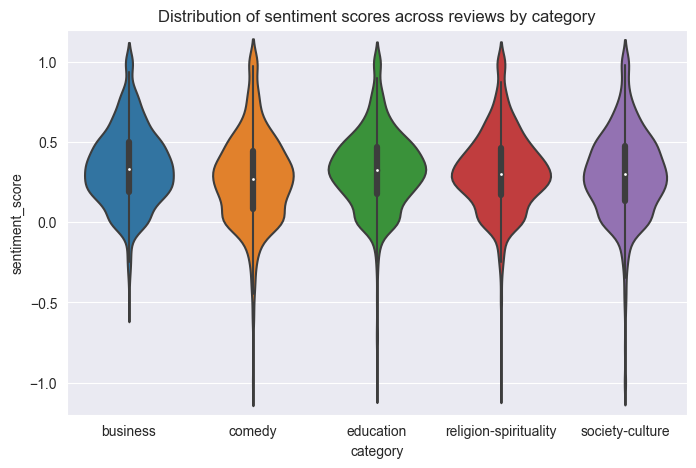

<IPython.core.display.Javascript object>

In [93]:
plt.figure(figsize=(8, 5))
ax = sns.violinplot(x=reviews_top_cat["category"], y=reviews_top_cat["sentiment_score"])
ax.set_ylim(-1.2, 1.2)
ax.set_title("Distribution of sentiment scores across reviews by category")

## 1.4. What words appear the most in positive/negative reviews?

##### Main insights and observations:
- In positive reviews (ratings higher than 3), the most common words include: love, great, thank you, funny, life, work, best, amazing.
- In negative reviews (ratings lower than 3), the most common words include: good, better, annoying, hard, love, doesn't, bad.

##### Additional notes:
- Due to the size of the data, we have selected random samples of size 1000 for each category.

In [85]:
# get a dataframe with positive reviews encoded as 1
reviews_positive_encoding = pd.read_sql(
    """
        SELECT c.category, 
               CASE 
                 WHEN r.rating > 3 THEN 1 ELSE 0 END
               AS positive_rating,
               r.content
        FROM categories c
        JOIN reviews r 
        ON c.podcast_id = r.podcast_id
        WHERE c.category IN ({})
              AND positive_rating = 1
        ORDER BY c.category;
            """.format(
        ",".join("?" * len(top_categories)),
    ),
    conn,
    params=top_categories,
)

reviews_positive_encoding

,category,positive_rating,content
0,arts,1,Thanks for providing these insights. Really e...
1,arts,1,Super excited to see this podcast grow. So man...
2,arts,1,I find Tedx talks very inspirational but I oft...
3,arts,1,"I love this podcast, it is so good."
4,arts,1,Ok so I am in love with this podcast.
...,...,...,...
1928066,tv-film,1,So I’m playing catch-up again with the episode...
1928067,tv-film,1,My fav podcast ever! Big fan
1928068,tv-film,1,There’s a universe out there where Mano and I ...
1928069,tv-film,1,I have enjoyed these podcasts about the on and...


<IPython.core.display.Javascript object>

In [13]:
reviews_positive_encoding = pd.read_sql(
    """
    SELECT t.category, t.positive_rating, t.content
    FROM (
        SELECT c.category, 
               CASE WHEN r.rating > 3 THEN 1 ELSE 0 END AS positive_rating,
               r.content,
               ROW_NUMBER() OVER (PARTITION BY c.category ORDER BY RANDOM()) AS row_num
        FROM categories c
        JOIN reviews r ON c.podcast_id = r.podcast_id
        WHERE c.category IN ({})
    ) t
    WHERE t.positive_rating = 1 AND t.row_num <= 1000
    ORDER BY t.category;
    """.format(
        ",".join("?" * len(top_categories))
    ),
    conn,
    params=top_categories,
)

reviews_positive_encoding

,category,positive_rating,content
0,arts,1,I thoroughly enjoy listening to the Food Netwo...
1,arts,1,"Not quite sure how they do it - website, iPad ..."
2,arts,1,"I love this podcast so much, But to be honest ..."
3,arts,1,I love the axe and crown! It was recced to me ...
4,arts,1,This podcast is chock full of one of Burner Cu...
...,...,...,...
9214,tv-film,1,I stumbled upon this podcast last summer and i...
9215,tv-film,1,Alison Hannigan was a very disappointing guest...
9216,tv-film,1,If you give less than 5 stars this show just i...
9217,tv-film,1,"Dwaine and David provide in-depth, fun and int..."


<IPython.core.display.Javascript object>

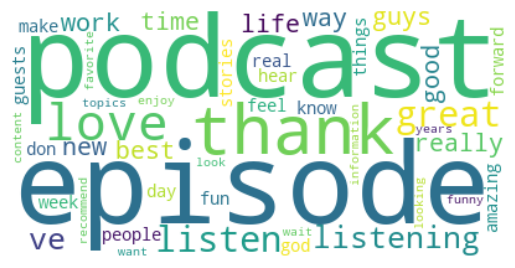

[('podcast', 5410),
 ('love', 3362),
 ('great', 2440),
 ('listen', 1782),
 ('listening', 1489),
 ('like', 1477),
 ('just', 1403),
 ('episode', 1131),
 ('thank', 1115),
 ('ve', 1102),
 ('really', 1093),
 ('life', 1044),
 ('time', 952),
 ('good', 913),
 ('work', 885),
 ('podcasts', 851),
 ('guys', 777),
 ('best', 752),
 ('way', 738),
 ('new', 731),
 ('episodes', 722),
 ('people', 658),
 ('guests', 627),
 ('know', 626),
 ('real', 601),
 ('hear', 587),
 ('fun', 567),
 ('amazing', 552),
 ('god', 551),
 ('feel', 549),
 ('make', 531),
 ('thanks', 530),
 ('forward', 524),
 ('day', 522),
 ('don', 522),
 ('week', 497),
 ('things', 482),
 ('stories', 463),
 ('topics', 442),
 ('look', 441),
 ('want', 432),
 ('enjoy', 431),
 ('years', 431),
 ('funny', 423),
 ('content', 416),
 ('favorite', 410),
 ('looking', 408),
 ('recommend', 402),
 ('information', 401),
 ('wait', 401)]

<IPython.core.display.Javascript object>

In [16]:
hf.plot_wordcloud(reviews_positive_encoding, "content")

In [17]:
reviews_negative_encoding = pd.read_sql(
    """
    SELECT t.category, t.negative_rating, t.content
    FROM (
        SELECT c.category, 
               CASE WHEN r.rating < 3 THEN 1 ELSE 0 END AS negative_rating,
               r.content,
               ROW_NUMBER() OVER (PARTITION BY c.category ORDER BY RANDOM()) AS row_num
        FROM categories c
        JOIN reviews r ON c.podcast_id = r.podcast_id
        WHERE c.category IN ({})
    ) t
    WHERE t.negative_rating = 1 AND t.row_num <= 1000
    ORDER BY t.category;
    """.format(
        ",".join("?" * len(top_categories))
    ),
    conn,
    params=top_categories,
)

reviews_negative_encoding

,category,negative_rating,content
0,arts,1,On fourth episode in 2020. Would recommend! Lo...
1,arts,1,I use to be a big supporter of Book riot and a...
2,arts,1,Another podcast I listen to mentioned this one...
3,arts,1,I loved Doe Files. Somehow the Doe Files I was...
4,arts,1,Bad. So bad. Basic white chick from LA telling...
...,...,...,...
580,tv-film,1,They are both dumb annoying and don't know the...
581,tv-film,1,UPDATE: Would you guys have whined that Dr. Ki...
582,tv-film,1,How is it that she can get away with the way s...
583,tv-film,1,Olivia is my favorite and she brings good conv...


<IPython.core.display.Javascript object>

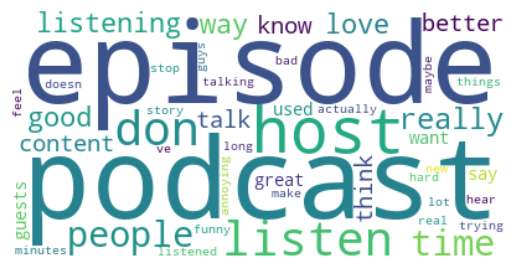

[('podcast', 268),
 ('like', 203),
 ('just', 189),
 ('listen', 123),
 ('don', 114),
 ('episode', 106),
 ('people', 98),
 ('time', 96),
 ('really', 83),
 ('listening', 77),
 ('way', 76),
 ('good', 65),
 ('episodes', 62),
 ('love', 60),
 ('host', 58),
 ('content', 55),
 ('podcasts', 55),
 ('better', 52),
 ('know', 50),
 ('talk', 50),
 ('think', 50),
 ('great', 48),
 ('guests', 46),
 ('used', 45),
 ('want', 45),
 ('say', 43),
 ('talking', 43),
 ('ve', 42),
 ('make', 41),
 ('hosts', 39),
 ('bad', 37),
 ('new', 36),
 ('doesn', 35),
 ('hear', 35),
 ('story', 35),
 ('actually', 34),
 ('things', 34),
 ('annoying', 33),
 ('hard', 33),
 ('feel', 32),
 ('funny', 32),
 ('guys', 32),
 ('lot', 32),
 ('trying', 32),
 ('minutes', 31),
 ('real', 31),
 ('stop', 31),
 ('listened', 30),
 ('long', 30),
 ('maybe', 30)]

<IPython.core.display.Javascript object>

In [18]:
hf.plot_wordcloud(reviews_negative_encoding, "content")

# 2. Statistical Inference

##### Research Question:
Is there a significant difference between the population proportions of positive reviews for podcast categories Business and Sports?

##### Populations: 
All reviews for podcasts in categories Business and Sports.

##### Parameter of Interest:
p1 - p2

##### Testing strategy:
Test for a significant difference in the population proportions of positive reviews for podcast categories Business and Sports at the 10% significance level.

##### Outcomes:
We fail to reject the Null Hypothesis. The difference in proportions in both categories is not statistically significant.

In [20]:
category_reviews_share

,category,num_podcasts,num_reviews,num_positive,positive_share,negative_count,negative_share
0,society-culture,18710,441874,385416,0.872231,56458,0.127769
1,education,12628,221831,210731,0.949962,11100,0.050038
2,comedy,12464,350848,314287,0.895792,36561,0.104208
3,religion-spirituality,12190,146633,140101,0.955453,6532,0.044547
4,business,12058,210081,200919,0.956388,9162,0.043612
5,arts,8953,136508,126334,0.925470,10174,0.074530
6,sports,8388,175709,156839,0.892607,18870,0.107393
7,health-fitness,8123,174310,164064,0.941220,10246,0.058780
8,christianity,7954,86341,82317,0.953394,4024,0.046606
9,tv-film,7714,169915,147063,0.865509,22852,0.134491


<IPython.core.display.Javascript object>

In [32]:
subset_df = category_reviews_share[category_reviews_share['category'].isin(['business', 'sports'])]

business_reviews = subset_df[subset_df['category'] == 'business']
sports_reviews = subset_df[subset_df['category'] == 'sports']

business_positive = business_reviews['num_positive']
business_total = business_reviews['num_reviews']

sports_positive = sports_reviews['num_positive']
sports_total = sports_reviews['num_reviews']

# simulation-based hypothesis test
num_simulations = 1000
num_samples = 1000

diff_proportions = []

for _ in range(num_simulations):
    business_sample = np.random.binomial(business_total, business_positive / business_total, size=num_samples)
    sports_sample = np.random.binomial(sports_total, sports_positive / sports_total, size=num_samples)
    
    proportion_diff = (business_sample.mean() / business_total.mean()) - (sports_sample.mean() / sports_total.mean())
    diff_proportions.append(proportion_diff)

observed_diff = (business_positive.sum() / business_total.sum()) - (sports_positive.sum() / sports_total.sum())

p_value = (np.abs(diff_proportions) >= np.abs(observed_diff)).mean()

alpha = 0.10

if p_value < alpha:
    print("p value: ", p_value)
    print("Reject the null hypothesis")
else:
    print("p value: ", p_value)
    print("Fail to reject the null hypothesis")


p value:  0.463
Fail to reject the null hypothesis


<IPython.core.display.Javascript object>